<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment2/MachineLearningAssignment2SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libaries and data

# Loading libraries and Data in

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
#uploading and reading RESTler output file with test cases
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t', delimiter=None, header='infer', names=None, index_col=None)

Saving Sentiment140.tenPercent.sample.tweets.tsv to Sentiment140.tenPercent.sample.tweets.tsv


# Data Exploration

Check Size of Data

In [3]:
print(dataset.head())
print(dataset.info())

   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Check if any missing values

In [4]:
print(dataset.isnull().values.any())

False


In [5]:
df = dataset

print("Number of duplicates before dropping:  " + str(len(df[df.duplicated()])))

df.drop_duplicates(keep = False, inplace = True)
print("Number of duplicates after dropping:  " + str(len(df[df.duplicated()])))

Number of duplicates before dropping:  553
Number of duplicates after dropping:  0


Checking if data balanced

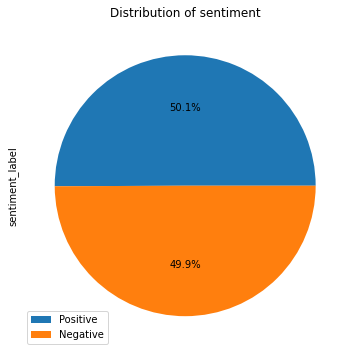

In [6]:
df['sentiment_label'] = df.sentiment_label.apply(lambda x: 1 if x == 4 else 0)

df['sentiment_label'].value_counts().plot.pie(figsize=(6,6),title="Distribution of sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

# Data Pre-processing

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
print("Processing data...")
df['clean']=df['tweet_text'].map(clean)
df['clean_text']=df['clean'].apply(lambda x: " ".join([str(word) for word in x]))

Processing data...


Convert into numerical data

Creating word clouds...


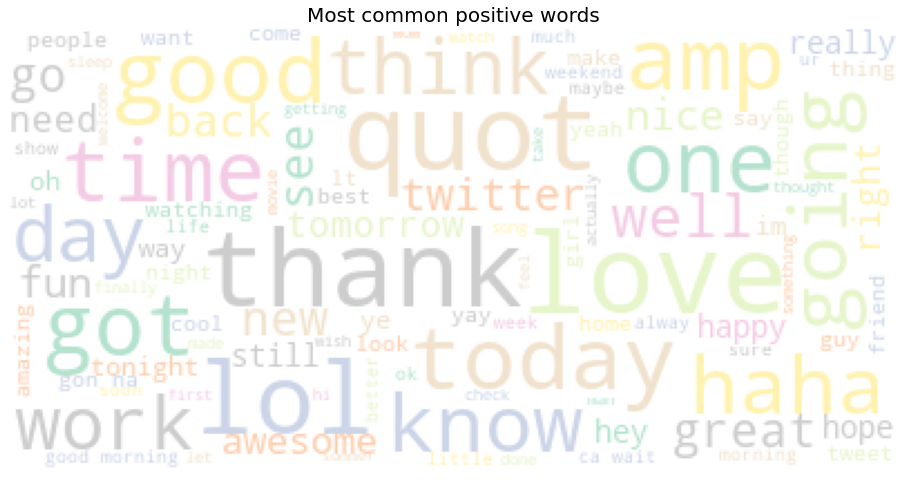

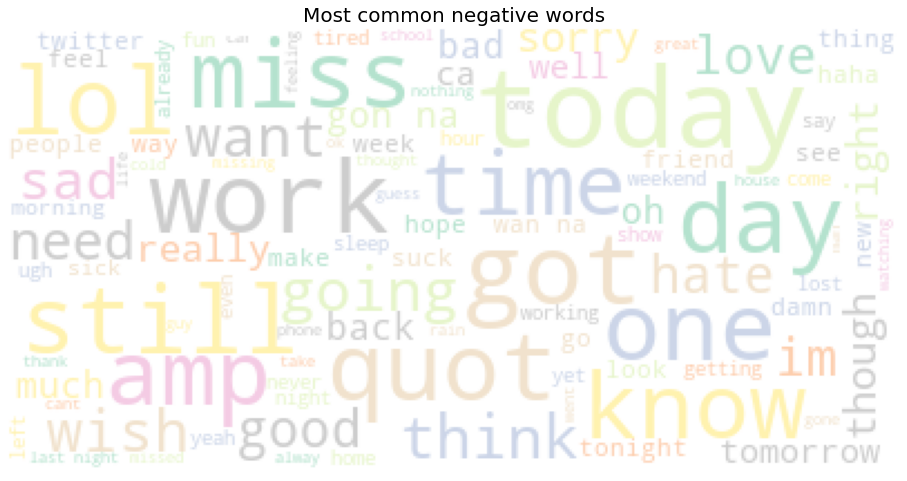

In [9]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')

print("Creating word clouds...")
positive_words=" ".join(df[df.sentiment_label==1]['clean_text'].values)
negative_words=" ".join(df[df.sentiment_label==0]['clean_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")


# Converting

In [16]:
#Split data into training and testing sets 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =  train_test_split(df['clean_text'], 
      df['sentiment_label'], test_size = 0.2, random_state = 42)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
print(x_train_counts.shape)
print(x_train_tfidf.shape)

#Output :(25569, 27304) (25569, 27304)
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)
print(x_test_counts.shape)
print(x_test_tfidf.shape)

(127304, 89465)
(127304, 89465)
(31827, 89465)
(31827, 89465)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train_tfidf,y_train)
predictions = model.predict(x_test_tfidf)
#Confusion Matrix 
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(y_test,predictions)
#Output: array([[5898,   39],        
#               [ 207,  249]], dtype=int64)
#f1-score
f1_score(y_test,predictions)
#Output : 0.6693548387096774
#Accuracy_score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)*100

In [10]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(df['clean_text']).toarray()

# Machine Learning

In [11]:
X = processed_features   #Feature Matrix
y = df["sentiment_label"]          #Target Variable

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_features, y, test_size=0.2, random_state=0)

In [14]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)
predictions = text_classifier.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# # Support Vector Machines
# from sklearn.svm import LinearSVC
# models['Support Vector Machines'] = LinearSVC()

# # Decision Trees
# from sklearn.tree import DecisionTreeClassifier
# models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# # Naive Bayes
# from sklearn.naive_bayes import GaussianNB
# models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [ ]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

In [ ]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.tight_layout()